# Dependencies

## Imports

In [1]:
# imports 
# base python
import os
import copy
from sys import getsizeof

# scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, interp2d
from sklearn import preprocessing
import matplotlib.tri as tri

plt.rcParams["figure.figsize"] = (20,7)
plt.rcParams["font.size"] = 20

#ase
from ase.io import gen, vasp, xyz, extxyz, dftb
from ase.io.dftb import read_dftb_velocities, write_dftb_velocities
from ase.calculators.dftb import Dftb
from ase import Atoms, Atom
from ase.cell import Cell
from ase.constraints import FixAtoms
from ase.visualize import view
from ase.build import make_supercell
from ase.visualize.plot import plot_atoms
from ase.build import add_adsorbate
import nglview
from ase.geometry.analysis import Analysis

#dscribe
from dscribe.descriptors import SOAP
from dscribe.descriptors import MBTR
from dscribe.kernels import REMatchKernel
from dscribe.kernels import AverageKernel

from sklearn import preprocessing


#quippy 
from ase.build import bulk
from ase.optimize import LBFGS
from ase.visualize import view
from quippy.potential import Potential


#misc
import similaritymeasures


_ColormakerRegistry()

## Functions

In [2]:
def show_atoms_grid(data, rotation = '-0x,0y,0z', save= False, filename = 'grid_configs'):
    '''
    Where data is list of Atoms objects
    '''
    dim = int(np.ceil(np.sqrt(len(data))))
    fig, axarr = plt.subplots(dim, dim, figsize=(25, 25))
    for i, config in enumerate(data):
        plot_atoms(config, axarr[i%dim,i//dim], rotation = rotation)
    if save:
        fig.savefig(filename + ".png")
        
def normalize(y,x):
    """
    Takes y, x of data and returns normalized y
    """
    return y/np.trapz(y,x)

def KE(v_tot):
    "Returns KE of Ar+ in eV given total velocity"
    return 6.24E18 * 0.5 * 1.66E-27*39.95*(v_tot*1E5)**2

def v_from_KE(E):
    "Returns v(z) of Ar+ in eV given KE"
    return np.sqrt(E/(6.24E18 * 0.5 * 1.66E-27*39.95))/1E5

## Structures

In [3]:
mef = vasp.read_vasp("reference_files/CONTCAR_mef")
cf4 = vasp.read_vasp("reference_files/CONTCAR_cf4")
amorphous = vasp.read_vasp("reference_files/CONTCAR_amorphous_cubic")
xtl_n = vasp.read_vasp("reference_files/CONTCAR_nrich")
xtl_si = vasp.read_vasp("reference_files/CONTCAR_sirich")
xtl_si_fterm = vasp.read_vasp("reference_files/CONTCAR_sirich_fterm")
xtl2x2_sifterm = gen.read_gen("reference_files/2x2xtl_sifterm.gen")
xtl2x2 = gen.read_gen("reference_files/2x2xtl.gen")
heavy_bomb = vasp.read_vasp("reference_files/CONTCAR_heavy_bombard")

# DFT energy curve; read and plot

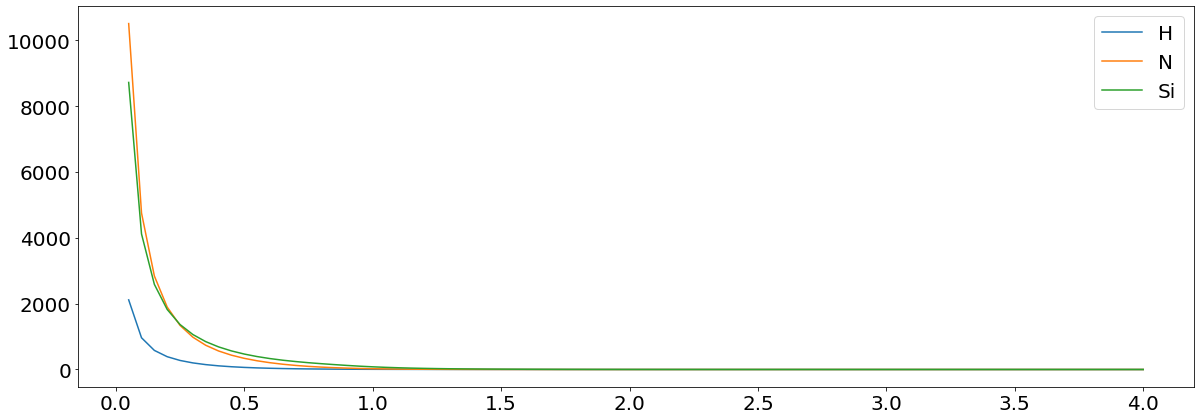

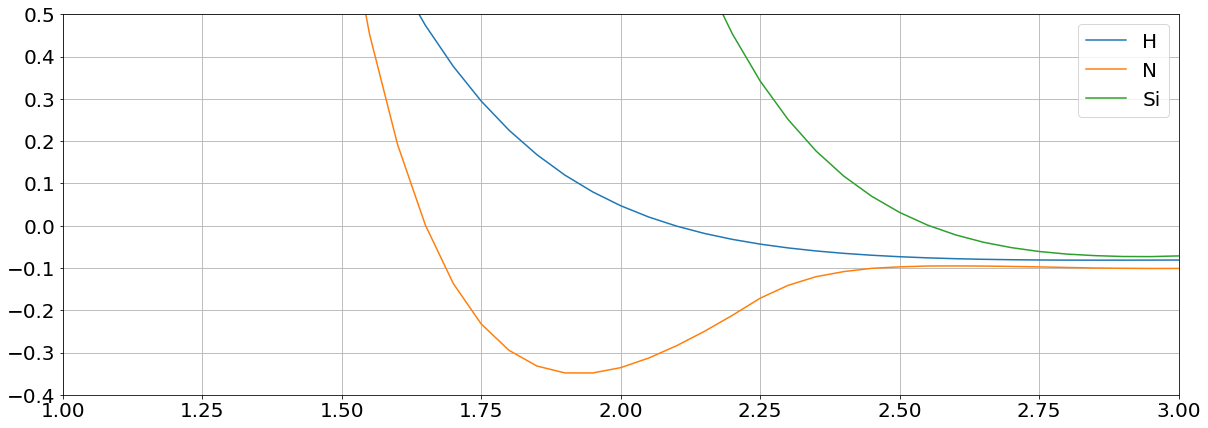

In [5]:
elems = ["H", "N", "Si"]
lowerlim, upperlim = 0, 4
dftEnergies = [pd.read_csv("../%senergies" % (i), header = None) for i in elems]
dftEnergies = pd.concat(dftEnergies, axis=1)
dftEnergies.columns = elems
dftEnergies.index = 80 - np.array(dftEnergies.index)
dftEnergies.index /= 20

dftEnergies = dftEnergies.sort_index()
dftEnergies = dftEnergies[np.bitwise_and(dftEnergies.index >= lowerlim, dftEnergies.index <= upperlim)]
dftEnergies.head()
dftEnergies.plot();
p = dftEnergies.plot(xlim = (1, 3), ylim = (-0.4, 0.5),grid = True);

# DFTB potential testing

In [8]:
distances = dftEnergies.index

nonrepulsivedata = {}
repulsivedata = {}

images = []
for element in elems:
    nonrepulsivedata[element] = np.array([])
    repulsivedata[element] = np.array([])
    for d in distances:
        atoms = Atoms("Ar%s" % (element), positions = [(0,0,0), (0,0,d)])
        nonrepulsivecalculator = Dftb(
            label='pairwise',
            atoms=atoms,
            Hamiltonian_MaxAngularMomentum_Ar='"p"',
            Hamiltonian_MaxAngularMomentum_N='"p"',
            Hamiltonian_MaxAngularMomentum_Si='"p"',
            Hamiltonian_MaxAngularMomentum_H='"s"',
            Hamiltonian_MaxAngularMomentum_C='"p"',
            Hamiltonian_PolynomialRepulsive = "SetForAll{No}",
            Driver_='ConjugateGradient',
            Driver_MaxForceComponent='1E10',
            Driver_KeepStationary='No',
            Driver_MaxSteps = 0
        )
        repulsivecalculator = Dftb(
            label='pairwise',
            atoms=atoms,
            Hamiltonian_MaxAngularMomentum_Ar='"p"',
            Hamiltonian_MaxAngularMomentum_N='"p"',
            Hamiltonian_MaxAngularMomentum_Si='"p"',
            Hamiltonian_MaxAngularMomentum_H='"s"',
            Hamiltonian_MaxAngularMomentum_C='"p"',
            Hamiltonian_PolynomialRepulsive = "SetForAll{Yes}",
            Driver_='ConjugateGradient',
            Driver_SCC = 'Yes',
            Driver_MaxForceComponent='1E10',
            Driver_KeepStationary='No',
            Driver_MaxSteps = 0
        )
        # get and append nonrepulsive energy
        atoms.set_calculator(nonrepulsivecalculator)
        nonrepulsivedata[element] = np.append(nonrepulsivedata[element],
                                              atoms.get_potential_energy())
        # get and append repulsive energy
        atoms.set_calculator(repulsivecalculator)
        repulsivedata[element] = np.append(repulsivedata[element], 
                                           atoms.get_potential_energy())
        images += [atoms]
    
repulsivedata = pd.DataFrame(repulsivedata)
repulsivedata.index = distances
repulsivedata.index.name = "Distance (Å)"

nonrepulsivedata = pd.DataFrame(nonrepulsivedata)
nonrepulsivedata.index = distances
nonrepulsivedata.index.name = "Distance (Å)"

KeyboardInterrupt: 

In [7]:
repulsivedata.head()

,H,N,Si
Distance (Å),,,
0.05,-137.476920,1385.322830,4513.879784
0.10,-187.963660,1087.542792,3666.669643
0.15,-221.097152,842.262994,2962.266448
0.20,-240.773257,640.494699,2378.584527
0.25,-195.915243,735.754526,2007.084714


In [8]:
nonrepulsivedata.head()

,H,N,Si
Distance (Å),,,
0.05,-116.331477,-168.238059,-139.555777
0.10,-116.331477,-168.238059,-139.555777
0.15,-116.331477,-168.238059,-139.555777
0.20,-116.305859,-168.951318,-139.863684
0.25,-61.943119,90.280446,-30.168682


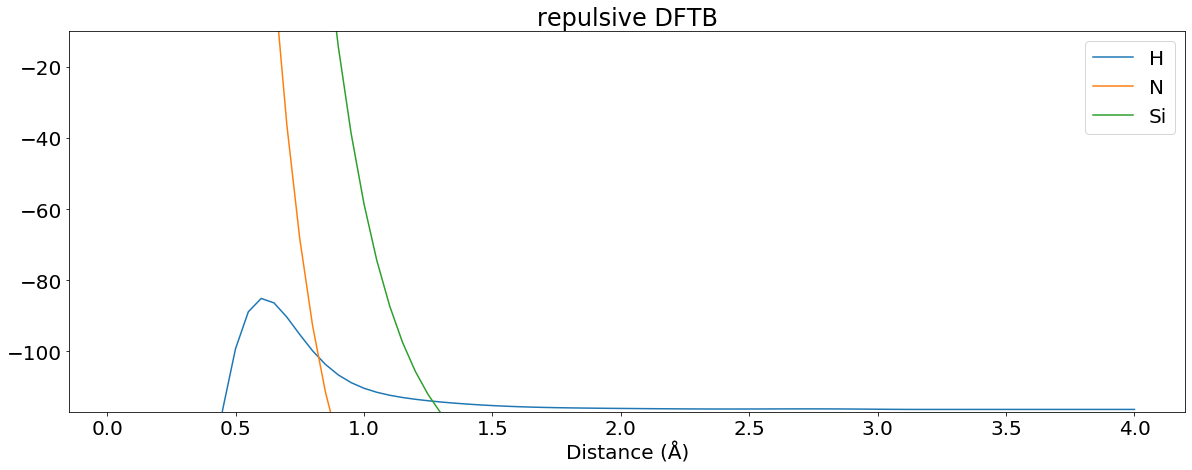

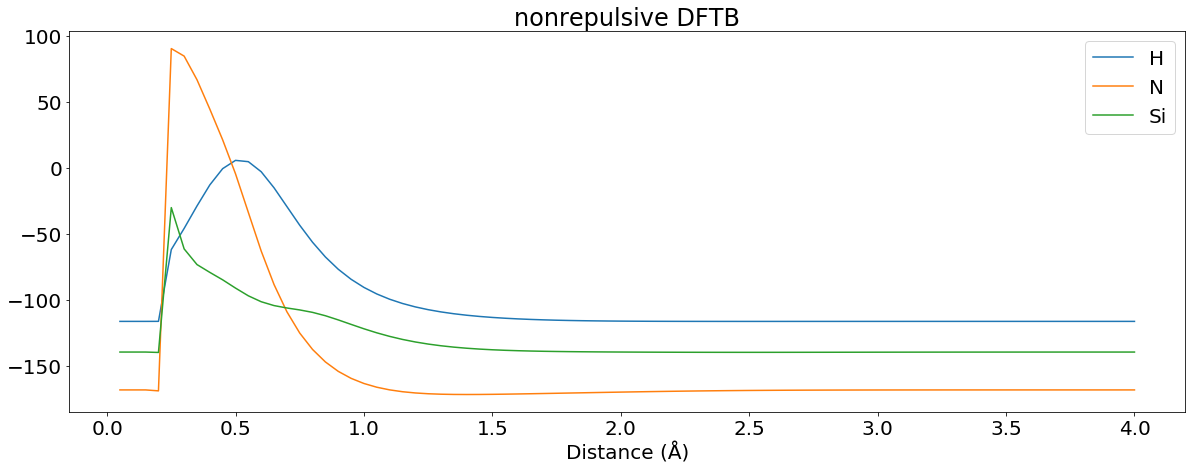

In [58]:
ymin,ymax = -117, -10
repulsivedata.plot(title='repulsive DFTB');
plt.ylim(ymin, ymax)
nonrepulsivedata.plot(title='nonrepulsive DFTB');
# plt.ylim(ymin, ymax);

In [118]:
def repulsive(r, c2, c3, c4, c5, c6, c7, c8, c9):
    rcut = 3
    r = rcut - r
    terms = np.array([c2, c3, c4, c5, c6, c7, c8, c9]) 
    exp = np.arange(2, 10)
    return np.array([np.sum(terms * np.power(i, exp)) for i in r])
def directfit(elem):
    '''
    HOF for specifiying element type
    Returns function that takes separation and coefficients, returns energy. 
    For purpose of comparing to distance and energy of DFT simulation via curve fitting. 
    '''
    def output(r, c2, c3, c4, c5, c6, c7, c8, c9, intercept):
        '''
        For purpose of directly fitting the parameter file
        The intercept term is a dummy; allow for the offset of DFTB baseline energy to match DFT;
        is discarded for purposes of parameter file
        '''
        energies = []
        print(c2, c3, c4, c5, c6, c7, c8, c9, intercept)
        prefix = os.environ["DFTB_PREFIX"]
        rcut = 6
        
        # write new parameter file
        for name in ['Ar-%s.skf' % elem, '%s-Ar.skf' % elem]:
            with open(prefix + name, 'r') as infile:
                with open(prefix+name + ".tmp", 'w') as outfile:
                    for i, line in enumerate(infile):
                        if i == 1:
                            newline = [0, c2, c3, c4, c5, c6, c7, c8, c9, rcut]
                            newline += [0] * 10
                            newline = [str(i) for i in newline]
                            newline = " ".join(newline)
                            outfile.write(newline)
                            outfile.write("\n")
                        else:
                            outfile.write(line)
            os.rename(prefix+name+'.tmp', prefix+name)


        for d in r:
            # initialize atoms object at one particular distance
            a = Atoms("Ar%s" % (elem), positions = [(0,0,0), (0,0,d)])
            # set up calculator
            repulsivecalculator = Dftb(
                    label='pairwise',
                    atoms=a,
                    Hamiltonian_MaxAngularMomentum_Ar='"p"',
                    Hamiltonian_MaxAngularMomentum_N='"p"',
                    Hamiltonian_MaxAngularMomentum_Si='"p"',
                    Hamiltonian_MaxAngularMomentum_H='"s"',
                    Hamiltonian_MaxAngularMomentum_C='"p"',
                    Hamiltonian_PolynomialRepulsive = "SetForAll{Yes}",
                    Driver_='ConjugateGradient',
                    Driver_MaxForceComponent='1E10',
                    Driver_KeepStationary='No',
                    Driver_MaxSteps = 0
            )
            a.set_calculator(repulsivecalculator)
            energies += [a.get_potential_energy()]
        return energies + intercept
    return output
def evaluateDFTBfit(elem):
    '''
    HOF for specifiying element type
    Returns function that takes separation and coefficients, returns energy. 
    For purpose of comparing to distance and energy of DFT simulation via curve fitting. 
    '''
    def output(r, c2, c3, c4, c5, c6, c7, c8, c9, intercept):
        '''
        Assess fitting outcome
        '''
        energies = []
        rcut = 6
        try:
            for d in r:
                # initialize atoms object at one particular distance
                a = Atoms("Ar%s" % (elem), positions = [(0,0,0), (0,0,d)])
                # set up calculator with 
                repulsivecalculator = Dftb(
                        label='pairwise',
                        atoms=a,
                        Hamiltonian_MaxAngularMomentum_Ar='"p"',
                        Hamiltonian_MaxAngularMomentum_N='"p"',
                        Hamiltonian_MaxAngularMomentum_Si='"p"',
                        Hamiltonian_MaxAngularMomentum_H='"s"',
                        Hamiltonian_MaxAngularMomentum_C='"p"',
                        Hamiltonian_PolynomialRepulsive = "SetForAll{Yes}",
                        Driver_='ConjugateGradient',
                        Driver_MaxForceComponent='1E10',
                        Driver_KeepStationary='No',
                        Driver_MaxSteps = 0
                )
                a.set_calculator(repulsivecalculator)
                energies += [a.get_potential_energy()]
        except:
            print('something bad happened')
        return energies + intercept
    return output

In [138]:
#fitting routine
mask = np.bitwise_and(dftEnergies.index < 3, dftEnergies.index > 1)
whichelem = "H"
elemFit = directfit(whichelem)
elemEval = evaluateDFTBfit(whichelem)
# baseline = elemEval([10]) # shift DFT energies to match TB baseline
# baseline = -140
# UNCOMMENT BELOW LINE TO FIT: DANGER, REWRITES PARAMETER FILES
# params, cov = curve_fit(elemFit, dftEnergies.index[mask], dftEnergies[whichelem][mask])

1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
1.0000000149011612 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
1.0 1.0000000149011612 1.0 1.0 1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0000000149011612 1.0 1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0000000149011612 1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0000000149011612 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0 1.0000000149011612 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0 1.0 1.0000000149011612 1.0 1.0
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0000000149011612 1.0
1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0000000149011612
0.06574951261950301 0.03537124480421616 -0.285914001557918 0.34440486122146174 -0.1908290351958808 0.055214275206136754 -0.008078137370314042 0.0004694610088921136 115.8405098782716
0.0657495135992471 0.03537124480421616 -0.285914001557918 0.34440486122146174 -0.1908290351958808 0.055214275206136754 -0.008078137370314042 0.0004694610088921136 115.8405098782716
0.06574951261950301 0.035371245331288784 -0.285914001557918 0.34440486

0.044830256410325 0.050352530700032976 -0.25281623655893776 0.28607888175715607 -0.15424310093801938 0.0441726356956653 -0.006478082452692107 0.0003810120941729856 115.97405888989178
0.044830256410325 0.05035252994972181 -0.25281623279168225 0.28607888175715607 -0.15424310093801938 0.0441726356956653 -0.006478082452692107 0.0003810120941729856 115.97405888989178
0.044830256410325 0.05035252994972181 -0.25281623655893776 0.2860788860200636 -0.15424310093801938 0.0441726356956653 -0.006478082452692107 0.0003810120941729856 115.97405888989178
0.044830256410325 0.05035252994972181 -0.25281623655893776 0.28607888175715607 -0.15424309863961808 0.0441726356956653 -0.006478082452692107 0.0003810120941729856 115.97405888989178
0.044830256410325 0.05035252994972181 -0.25281623655893776 0.28607888175715607 -0.15424310093801938 0.044172636353888864 -0.006478082452692107 0.0003810120941729856 115.97405888989178
0.044830256410325 0.05035252994972181 -0.25281623655893776 0.28607888175715607 -0.154243

0.03290423728343085 0.06486228262132339 -0.24222439706832388 0.25712463210071446 -0.13347200179148055 0.03711324701706803 -0.0053038723457914695 0.0003040614861417522 116.00699476217652
0.03290423728343085 0.06486228262132339 -0.24222439706832388 0.25712463210071446 -0.13347200179148055 0.03711324701706803 -0.005303872424825327 0.0003040614906726214 116.00699476217652
0.03290423728343085 0.06486228262132339 -0.24222439706832388 0.25712463210071446 -0.13347200179148055 0.03711324701706803 -0.005303872424825327 0.0003040614861417522 116.00699649081545
0.027184456507534125 0.07379997341566803 -0.24630857412524898 0.25593850122146283 -0.1316129400743203 0.036382959619158446 -0.005175891383311195 0.0002954464904479334 116.02717715423863
0.027184456912614095 0.07379997341566803 -0.24630857412524898 0.25593850122146283 -0.1316129400743203 0.036382959619158446 -0.005175891383311195 0.0002954464904479334 116.02717715423863
0.027184456507534125 0.07379997451537333 -0.24630857412524898 0.25593850

0.02506486338439188 0.06345211974125246 -0.22132952902991868 0.23466700689620526 -0.12255288341060741 0.03432590917748613 -0.004940897306403715 0.00028505036901869106 116.05880595349691
0.02506486338439188 0.06345211879574221 -0.2213295257318517 0.23466700689620526 -0.12255288341060741 0.03432590917748613 -0.004940897306403715 0.00028505036901869106 116.05880595349691
0.02506486338439188 0.06345211879574221 -0.22132952902991868 0.23466701039301616 -0.12255288341060741 0.03432590917748613 -0.004940897306403715 0.00028505036901869106 116.05880595349691
0.02506486338439188 0.06345211879574221 -0.22132952902991868 0.23466700689620526 -0.12255288158442713 0.03432590917748613 -0.004940897306403715 0.00028505036901869106 116.05880595349691
0.02506486338439188 0.06345211879574221 -0.22132952902991868 0.23466700689620526 -0.12255288341060741 0.03432590968898204 -0.004940897306403715 0.00028505036901869106 116.05880595349691
0.02506486338439188 0.06345211879574221 -0.22132952902991868 0.23466700

0.024445949261942556 0.05374358344161805 -0.19467537785875683 0.2066997436473219 -0.10758643546505135 0.02997827061268978 -0.004287632335436373 0.00024523424250589806 116.06762956269883
0.024445949261942556 0.05374358344161805 -0.19467537785875683 0.2066997436473219 -0.10758643546505135 0.029978270165978742 -0.004287632271545672 0.00024523424250589806 116.06762956269883
0.024445949261942556 0.05374358344161805 -0.19467537785875683 0.2066997436473219 -0.10758643546505135 0.029978270165978742 -0.004287632335436373 0.000245234246160173 116.06762956269883
0.024445949261942556 0.05374358344161805 -0.19467537785875683 0.2066997436473219 -0.10758643546505135 0.029978270165978742 -0.004287632335436373 0.00024523424250589806 116.06763129224129
0.023677746951450862 0.049448724491737775 -0.1855520531781451 0.19935571614411196 -0.10445816963516368 0.029221141782871725 -0.0041883000917349355 0.00023971463044693901 116.08761112977697
0.023677747304276787 0.049448724491737775 -0.1855520531781451 0.19

0.02227550083402153 0.043272017474019826 -0.16366229182004227 0.1748259450425811 -0.09106253432498795 0.02532698457081885 -0.003608653886236543 0.0002049162614221043 116.0913331345423
0.02227550116595236 0.043272017474019826 -0.16366229182004227 0.1748259450425811 -0.09106253432498795 0.02532698457081885 -0.003608653886236543 0.0002049162614221043 116.0913331345423
0.02227550083402153 0.043272018118823134 -0.16366229182004227 0.1748259450425811 -0.09106253432498795 0.02532698457081885 -0.003608653886236543 0.0002049162614221043 116.0913331345423
0.02227550083402153 0.043272017474019826 -0.16366228938128408 0.1748259450425811 -0.09106253432498795 0.02532698457081885 -0.003608653886236543 0.0002049162614221043 116.0913331345423
0.02227550083402153 0.043272017474019826 -0.16366229182004227 0.1748259476476907 -0.09106253432498795 0.02532698457081885 -0.003608653886236543 0.0002049162614221043 116.0913331345423
0.02227550083402153 0.043272017474019826 -0.16366229182004227 0.1748259450425811

0.019050459953433595 0.04190656014938284 -0.15470434144625747 0.1659013583300989 -0.0868259996243808 0.024236594742368802 -0.0034615180125495415 0.0001967256269583893 116.11968389719382
0.019050460237307568 0.04190656014938284 -0.15470434144625747 0.1659013583300989 -0.0868259996243808 0.024236594742368802 -0.0034615180125495415 0.0001967256269583893 116.11968389719382
0.019050459953433595 0.04190656077383925 -0.15470434144625747 0.1659013583300989 -0.0868259996243808 0.024236594742368802 -0.0034615180125495415 0.0001967256269583893 116.11968389719382
0.019050459953433595 0.04190656014938284 -0.15470433914098314 0.1659013583300989 -0.0868259996243808 0.024236594742368802 -0.0034615180125495415 0.0001967256269583893 116.11968389719382
0.019050459953433595 0.04190656014938284 -0.15470434144625747 0.1659013608022218 -0.0868259996243808 0.024236594742368802 -0.0034615180125495415 0.0001967256269583893 116.11968389719382
0.019050459953433595 0.04190656014938284 -0.15470434144625747 0.165901

0.017476157311601997 0.044220530109289634 -0.15583971008171477 0.16603208913306702 -0.08678583624413203 0.024233073505985525 -0.0034642202000072404 0.00019712238589646833 116.12524898803764
0.017476157311601997 0.044220530109289634 -0.15583971008171477 0.16603208665899613 -0.08678583495092229 0.024233073505985525 -0.0034642202000072404 0.00019712238589646833 116.12524898803764
0.017476157311601997 0.044220530109289634 -0.15583971008171477 0.16603208665899613 -0.08678583624413203 0.02423307386708646 -0.0034642202000072404 0.00019712238589646833 116.12524898803764
0.017476157311601997 0.044220530109289634 -0.15583971008171477 0.16603208665899613 -0.08678583624413203 0.024233073505985525 -0.0034642201483863367 0.00019712238589646833 116.12524898803764
0.017476157311601997 0.044220530109289634 -0.15583971008171477 0.16603208665899613 -0.08678583624413203 0.024233073505985525 -0.0034642202000072404 0.0001971223888338208 116.12524898803764
0.017476157311601997 0.044220530109289634 -0.1558397

0.01748463384443912 0.04421938132730084 -0.15584002334918653 0.16603204700916233 -0.08678583854406141 0.024233074135546723 -0.00346421979561394 0.00019712255851095042 116.12492024087959
0.017484634104980468 0.04421938132730084 -0.15584002334918653 0.16603204700916233 -0.08678583854406141 0.024233074135546723 -0.00346421979561394 0.00019712255851095042 116.12492024087959
0.01748463384443912 0.04421938198622097 -0.15584002334918653 0.16603204700916233 -0.08678583854406141 0.024233074135546723 -0.00346421979561394 0.00019712255851095042 116.12492024087959
0.01748463384443912 0.04421938132730084 -0.15584002102698924 0.16603204700916233 -0.08678583854406141 0.024233074135546723 -0.00346421979561394 0.00019712255851095042 116.12492024087959
0.01748463384443912 0.04421938132730084 -0.15584002334918653 0.1660320494832326 -0.08678583854406141 0.024233074135546723 -0.00346421979561394 0.00019712255851095042 116.12492024087959
0.01748463384443912 0.04421938132730084 -0.15584002334918653 0.1660320

params:  [ 1.74846338e-02  4.42193813e-02 -1.55840023e-01  1.66032047e-01
 -8.67858385e-02  2.42330741e-02 -3.46421980e-03  1.97122559e-04
  1.16124920e+02]


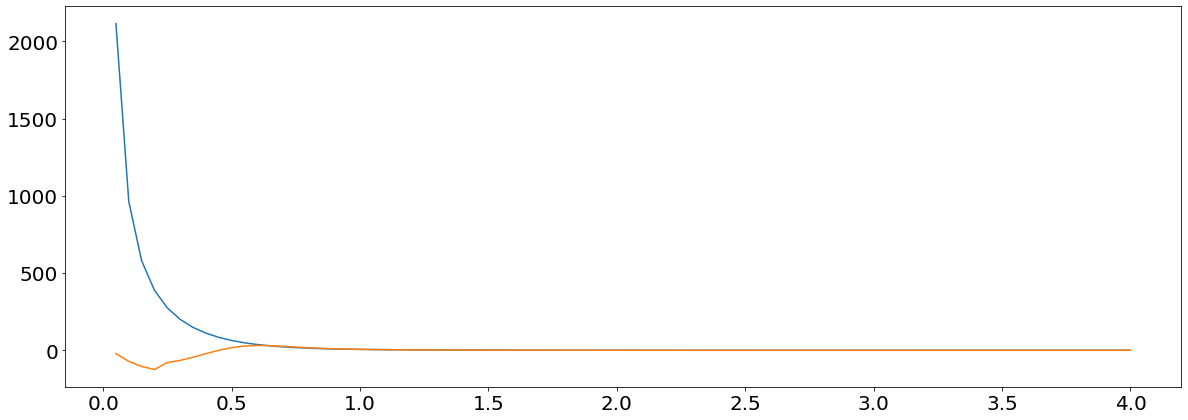

In [140]:
# evaluate
elemFit = directfit(whichelem)
elemEval = evaluateDFTBfit(whichelem)
print('params: ', params)
plt.plot(dftEnergies.index, dftEnergies[whichelem])
plt.plot(dftEnergies.index, elemEval(dftEnergies.index, *params))
# plt.ylim(-2, 5)

Plotting DFT vs repulsive DFTB curves

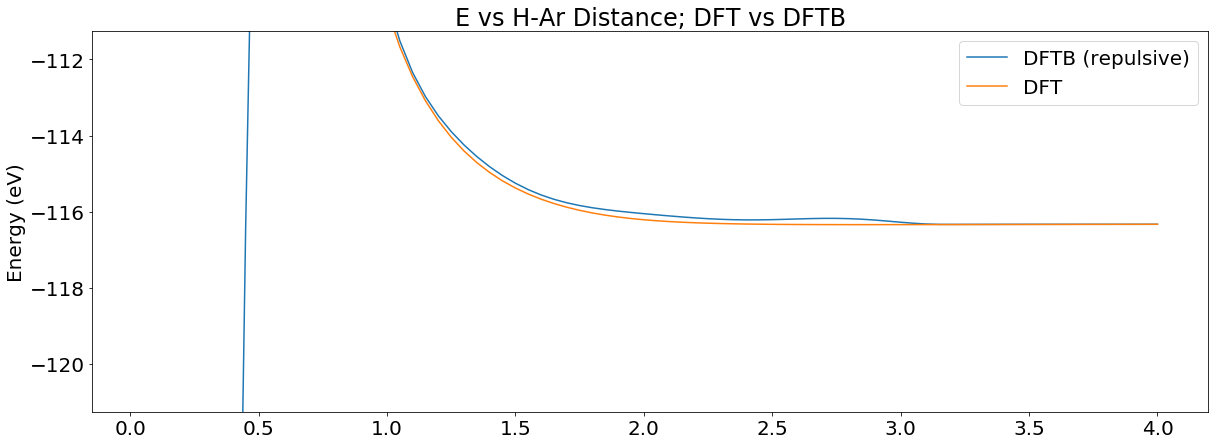

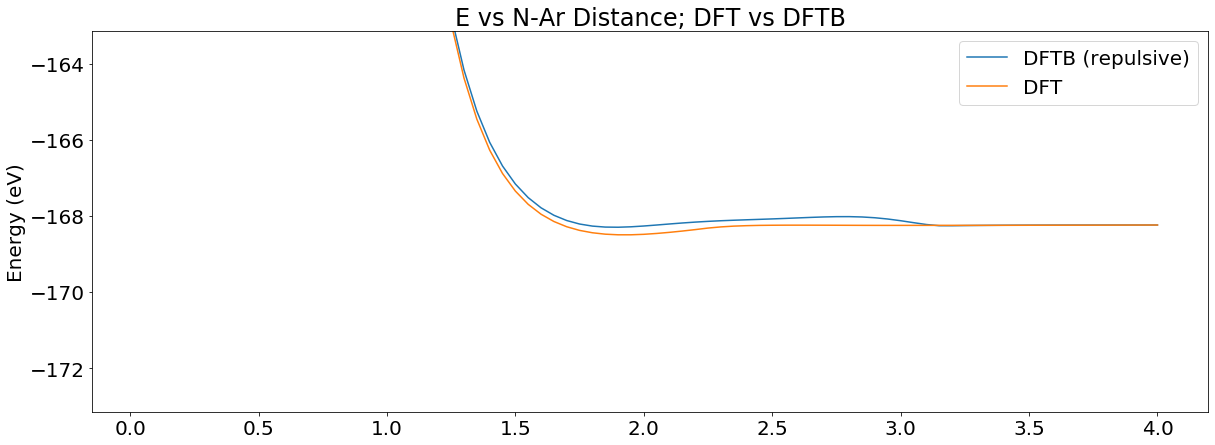

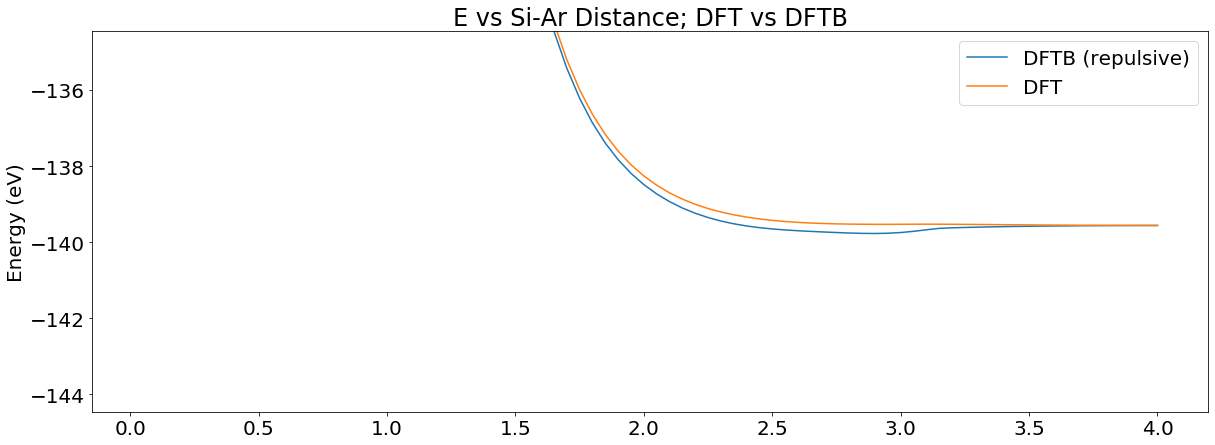

In [17]:
for whichelem in elems:
    plt.subplots()
    baseline = -dftEnergies[whichelem].iloc[-1]+ repulsivedata[whichelem].iloc[-1]
    plt.plot(repulsivedata.index, repulsivedata[whichelem] , label = "DFTB (repulsive)")
    plt.plot(dftEnergies[whichelem] + baseline, 
             label = "DFT")
    plt.title("E vs %s-Ar Distance; DFT vs DFTB" % (whichelem))
    plt.ylim(baseline - 5, baseline + 5)
    plt.legend()
    plt.ylabel("Energy (eV)")
    plt.savefig("Ecurves.png")
    # view(images)

Plotting DFT vs nonrepulsive DFTB curves

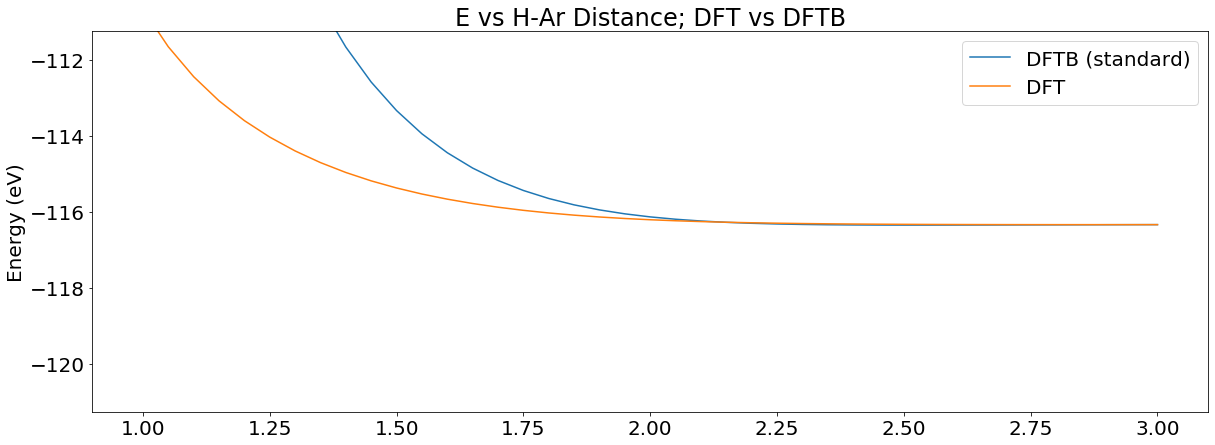

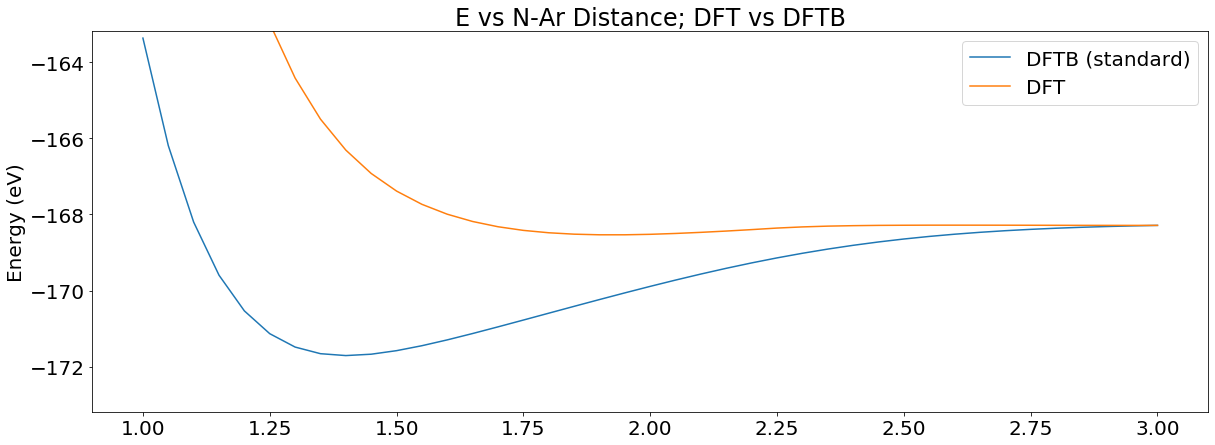

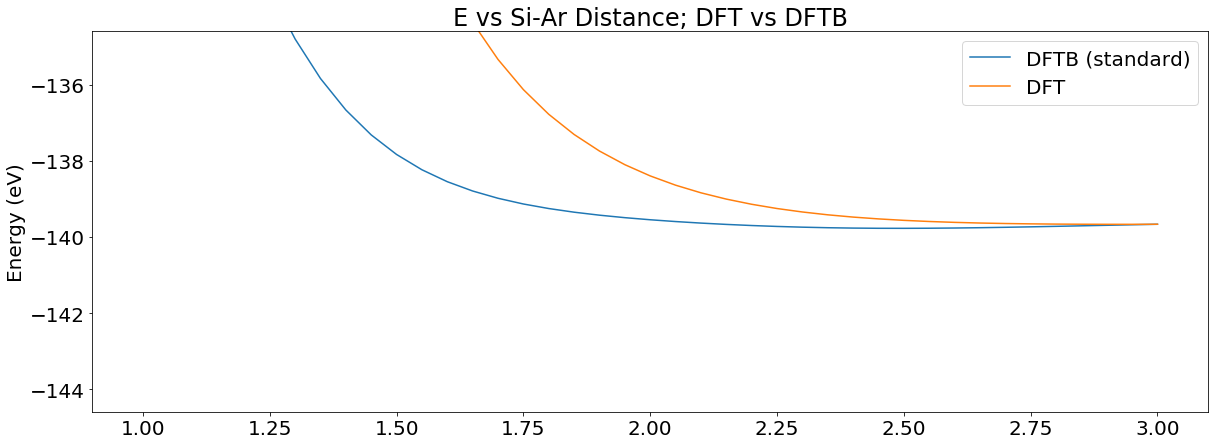

In [67]:
for whichelem in elems:
    plt.subplots()
    baseline = -dftEnergies[whichelem].iloc[-1]+ nonrepulsivedata[whichelem].iloc[-1]
    plt.plot(nonrepulsivedata.index, nonrepulsivedata[whichelem] , label = "DFTB (standard)")
    plt.plot(dftEnergies[whichelem] + baseline, 
             label = "DFT")
    plt.title("E vs %s-Ar Distance; DFT vs DFTB" % (whichelem))
    plt.ylim(baseline - 5, baseline + 5)
    plt.legend()
    plt.ylabel("Energy (eV)")
    plt.savefig("Ecurves.png")
    # view(images)

## Deprecated difference fitting version

[-1.07498198  0.39775341  2.1940975  -1.16461254 -1.42805104  0.8791884
  0.11351706 -0.13116243]
[-0.17372446  2.46908239  0.45845271 -3.63127858  1.67829525  1.55256586
 -1.47248468  0.35002963]
[ 0.17752584  2.01281029 -1.85986117 -2.95166883  4.658977    0.74775103
 -2.58858364  0.85864857]


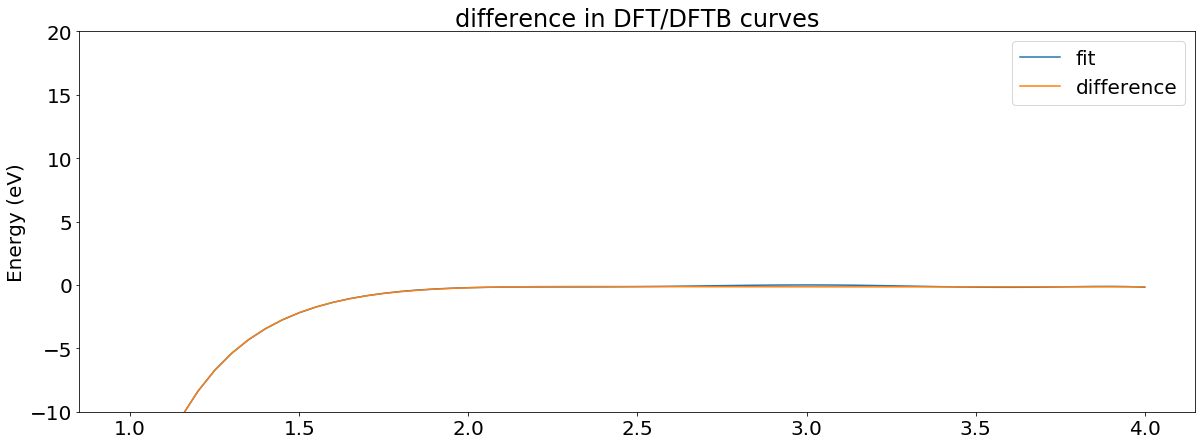

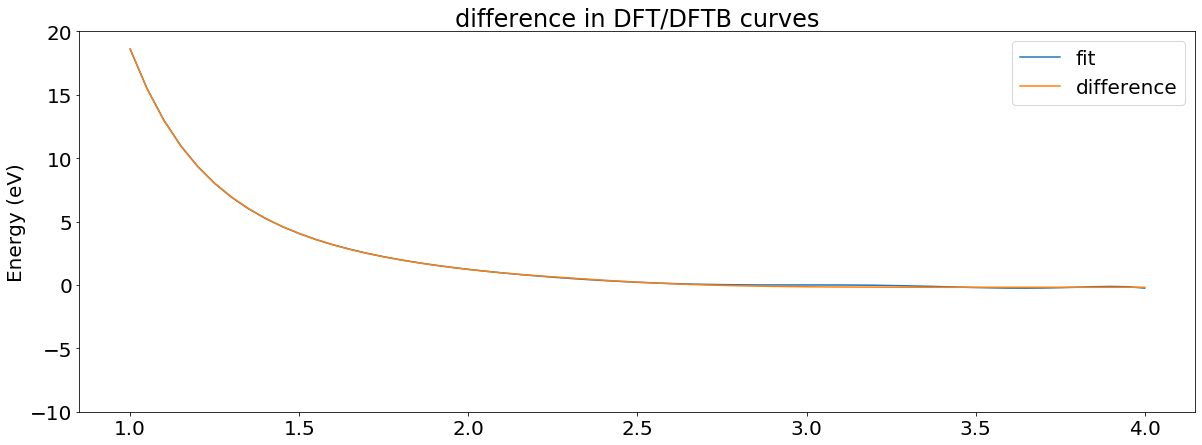

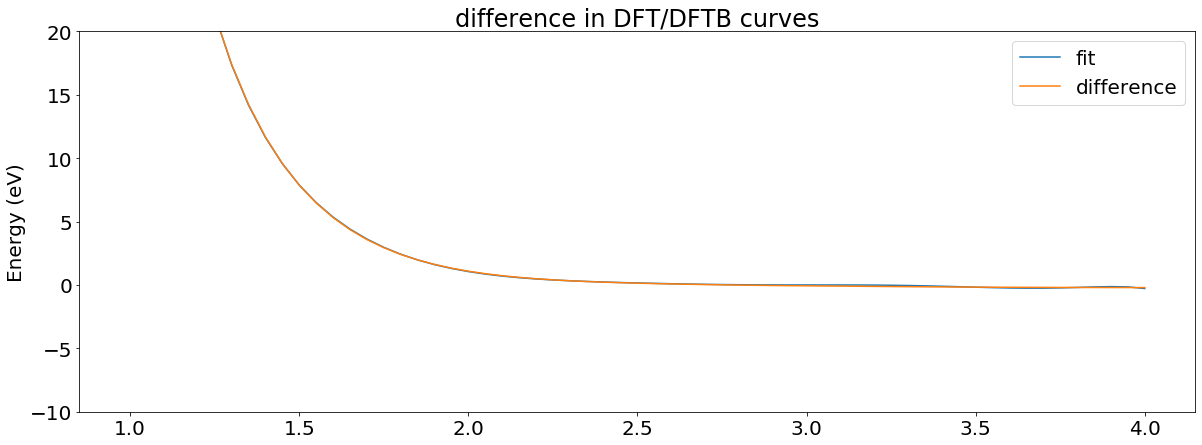

In [105]:
### calculate difference, fit, and plot
fits = {}
corrections = {}
for elem in elems:
    plt.subplots()
    dftb_0ed = nonrepulsivedata[elem]
    baseline = dftEnergies[elem].loc[4.0]+ nonrepulsivedata[elem].iloc[-1]
    dft_0ed = dftEnergies[elem] + baseline 
    differences = np.array(dft_0ed) - np.array(dftb_0ed)

    params, cov = curve_fit(repulsive, list(dftEnergies.index)[0:], differences[0:])
    fits[elem] = params
    print(params)
    plt.plot(dftEnergies.index, repulsive(dftEnergies.index, *params), label = "fit")
    plt.plot(dftEnergies.index, differences, label = "difference")
    corrections[elem] = repulsive(dftEnergies.index, *params)

    plt.title("difference in DFT/DFTB curves")
    plt.ylim(-10, 20)
    plt.legend()
    plt.ylabel("Energy (eV)")
    plt.savefig("Ecurves.png")
    # view(images)

NameError: name 'corrections' is not defined

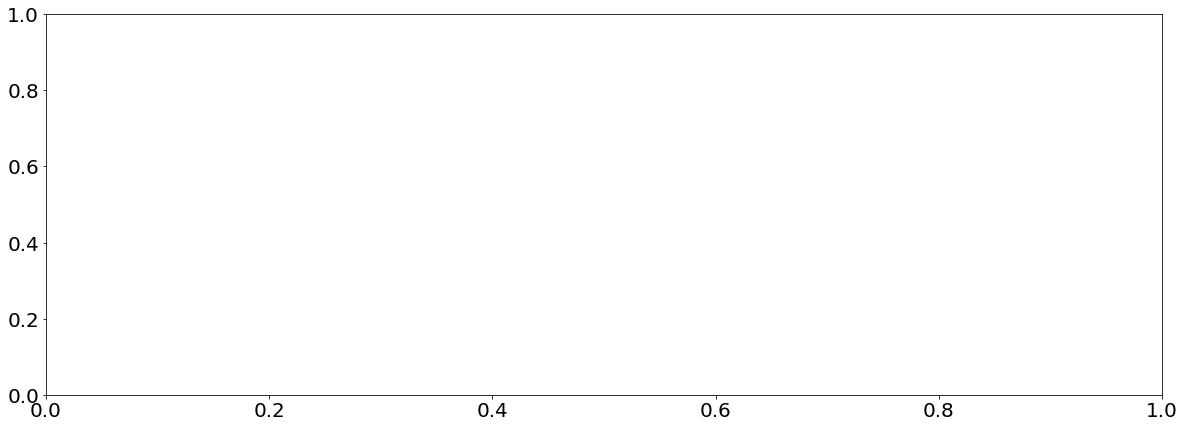

In [103]:
for whichelem in elems:
    plt.subplots()
    baseline = dftEnergies[whichelem].iloc[-1]+ nonrepulsivedata[whichelem].iloc[-1]
    plt.plot(nonrepulsivedata.index, nonrepulsivedata[whichelem] + corrections[whichelem]  , label = "DFTB (corrected)")
    plt.plot(dftEnergies[whichelem] + baseline, 
             label = "DFT")
    plt.title("E vs %s-Ar Distance; DFT vs DFTB" % (whichelem))
    plt.ylim(baseline - 5, baseline + 20)
    plt.legend()
    plt.ylabel("Energy (eV)")
    plt.savefig("Ecurves.png")
    # view(images)


## NH3 stuff

In [76]:
nh3 = Atoms('NH3', positions =
              [(0,0,0), (1,0,-.3), (-.7, -.7, -.2), (-.7, .7, -.3)])


calculator = Dftb(
            label='nh3',
            atoms=nh3,
            Driver_MovedAtoms = "2:-1",
            Hamiltonian_MaxAngularMomentum_Ar='"p"',
            Hamiltonian_MaxAngularMomentum_N='"p"',
            Hamiltonian_MaxAngularMomentum_Si='"p"',
            Hamiltonian_MaxAngularMomentum_H='"p"',
            Hamiltonian_MaxAngularMomentum_C='"p"',
            Driver_='ConjugateGradient',
            Driver_KeepStationary='No',
            Driver_MaxForceComponent='1E-10',
            Driver_MaxSteps=1000,
        )

nh3.set_calculator(calculator)

calculator.calculate(nh3)
nh3 = gen.read_gen('geo_end.gen')

In [6]:
silane = Atoms('SiH4', positions = [[ 1.91661264,  3.31967028, 14.619618  ],
       [ 1.7736752 ,  4.84714871, 14.73180419],
       [ 0.6094155 ,  2.69001805, 14.10864846],
       [ 2.28878213,  2.69255191, 15.97369353],
       [ 3.05605402,  3.04837682, 13.61269834]])
silane.positions -= silane.positions[0]
gen.write_gen('geo_end.gen', silane)


calculator = Dftb(
            label='silane',
            atoms=silane,
            Driver_MovedAtoms = "2:-1",
            Hamiltonian_MaxAngularMomentum_Ar='"p"',
            Hamiltonian_MaxAngularMomentum_N='"p"',
            Hamiltonian_MaxAngularMomentum_Si='"p"',
            Hamiltonian_MaxAngularMomentum_H='"p"',
            Hamiltonian_MaxAngularMomentum_C='"p"',
            Driver_='ConjugateGradient',
            Driver_KeepStationary='No',
            Driver_MaxForceComponent='1E-10',
            Driver_MaxSteps=1000,
        )

silane.set_calculator(calculator)

calculator.calculate(silane)
silane = gen.read_gen('geo_end.gen')
view(silane)

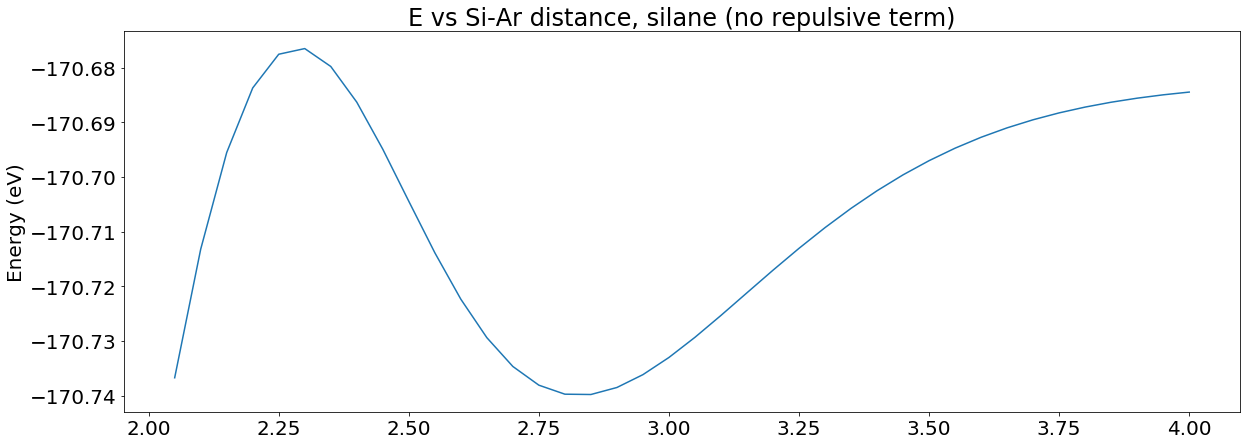

In [14]:
images = []
atomdata = np.array([])
testDistances = distances[distances > 2]
dangle = True
repulsive = "No"
for d in testDistances:
    atoms = silane.copy()
#     code for ammonia 
#     add_adsorbate(atoms, 'Ar', height = d, position = (0, 0))
#     code for silane
    disp = atoms.positions[0] - atoms.positions[-1]
    disp = disp/np.sqrt(np.sum(disp**2))
    disp *= d
    if dangle:
        del atoms[-1]
        disp = -disp
    atoms += Atom('Ar', position = disp)
    
    calculator = Dftb(
        label='silane',
        atoms=atoms,
        Hamiltonian_MaxAngularMomentum_Ar='"p"',
        Hamiltonian_MaxAngularMomentum_N='"p"',
        Hamiltonian_MaxAngularMomentum_Si='"p"',
        Hamiltonian_MaxAngularMomentum_H='"p"',
#         Hamiltonian_MaxAngularMomentum_C='"p"',
        Hamiltonian_PolynomialRepulsive = "SetForAll{%s}" % (repulsive),
        Driver_='ConjugateGradient',
        Driver_MaxForceComponent='1E10',
        Driver_KeepStationary='No',
        Driver_MaxSteps = 0
    )
    atoms.set_calculator(calculator)
    atomdata = np.append(atomdata, atoms.get_potential_energy())
    images += [atoms]

plt.plot(testDistances, atomdata)
if repulsive == "Yes":
    plt.title("E vs Si-Ar distance, silane (repulsive term)")
else:
    plt.title("E vs Si-Ar distance, silane (no repulsive term)")
plt.ylabel("Energy (eV)") 
# plt.ylim(-181.5, -180)
# plt.savefig("Ecurves.png")
view(images)

In [18]:
" ".join([str(i) for i in -disp/80])

'-0.03688448297082481 0.008781951560742986 0.032594665863599506'

In [15]:
atoms.cell = Cell(np.array([[10.0, 0, 0], [0, 10, 0], [0, 0, 10]]))
vasp.write_vasp("../CONTCARsilane.dangle", atoms, sort = True, vasp5= True)

In [71]:
Cell(np.array([[10.0, 0, 0], [0, 10, 0], [0, 0, 10]]))

Cell([10.0, 10.0, 10.0])

(-14, -12)

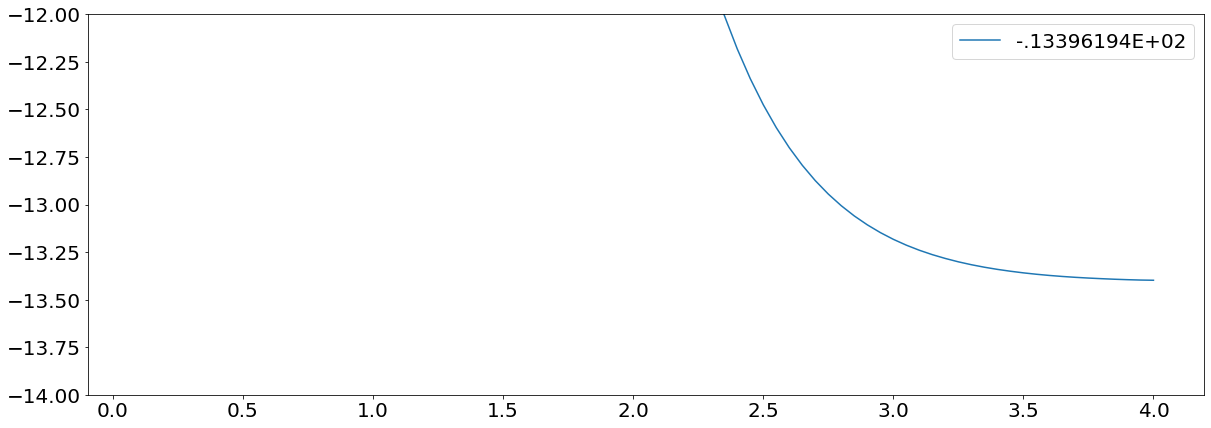

In [18]:
temp = pd.read_csv("../energies.dangle.silane")
# temp.columns = elems
temp.index = 80 - np.array(temp.index)
temp.index /= 20
p =temp.plot()
p.set_ylim(-14, -12)

In [ ]:
molecules_and_configs = ["nh3.lp", "nh3.side", "silane", 'silane.dangling']
lowerlim, upperlim = 0, 4
dftEnergies = [pd.read_csv("../%senergies" % (i), header = None) for i in elems]
dftEnergies = pd.concat(dftEnergies, axis=1)
dftEnergies.columns = elems
dftEnergies.index = 80 - np.array(dftEnergies.index)
dftEnergies.index /= 20

dftEnergies = dftEnergies.sort_index()
dftEnergies = dftEnergies[np.bitwise_and(dftEnergies.index >= lowerlim, dftEnergies.index <= upperlim)]
dftEnergies.head()
dftEnergies.plot();
p = dftEnergies.plot(xlim = (1, 3), ylim = (-0.4, 0.5),grid = True);